## Annotated phylogenetic tree using baltic

Note: tree is generated from logistic growth model output WITH outgroup MPXV_USA_2021_MD (ON676708) while parameter estimates (netau, r, tmrca) derived from model using only B.1 genomes.  

### Load libraries

In [1]:
import baltic as bt
import pandas as pd
import numpy as np
import itertools
import re
import copy


import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon
import matplotlib.ticker as ticker


from io import StringIO as sio
from io import BytesIO as csio

from IPython.display import HTML
from Bio import Phylo
from scipy.special import binom

import seaborn as sns
import geopandas

from datetime import datetime, timedelta

In [17]:
tree_path = '../out/logistic/hmpxv_logistic.trees'
t = bt.loadNexus(tree_path, tip_regex='_([0-9\-]+)$')

In [18]:
typeface='sans'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

In [19]:
t.traverse_tree()
t.treeStats()


Tree height: 1.132954
Tree length: 35.509426
strictly bifurcating tree

Numbers of objects in tree: 471 (235 nodes and 236 leaves)



### extract location from tip name, assign traits to each tip object

In [20]:
for k in t.Objects:
    if k.branchType=='leaf':
        if len(k.traits)<1:
            k.traits['location'] = re.split("\_",k.name)[-2]


### group and color by region

In [21]:
region = {('Canada','USA'):'North America',
          'Finland':'Northern Europe',
          ('Austria','Germany','Switzerland','UnitedKingdom','France','Belgium','Netherlands'):'Western Europe', 
          ('Slovakia','Slovenia'):'Central/Eastern Europe',
          ('Italy','Portugal','Spain'):'Southern Europe',
          ('Colombia','Peru'):'South America'}

color_code = {'North America': '#66c2a5', 
              'South America': '#fc8d62', 
              'Southern Europe': '#8da0cb',
              'Northern Europe': '#e78ac3',
              'Central/Eastern Europe': '#a6d854',
              'Western Europe': '#ffd92f'}

In [22]:
countries = [] 
country_counts = {}

regions = []
region_counts = {}

for k in t.Objects:
    if k.branchType=='leaf':
        countries.append(k.traits['location'])
        if k.traits['location'] in country_counts :
            country_counts[k.traits['location']] +=1
        else:
            country_counts[k.traits['location']] = 1
            
        k.traits['region'] = next(value for key, value in region.items() if k.traits['location'] in key)
        regions.append(k.traits['region'])
        if k.traits['region'] in region_counts:
            region_counts[k.traits['region']] += 1
        else:
            region_counts[k.traits['region']] = 1

country_counts['United Kingdom'] = country_counts.pop('UnitedKingdom')
country_counts['United States of America'] = country_counts.pop('USA') 

In [23]:
sorted(country_counts.items(), key=lambda x: x[1])

[('Netherlands', 3),
 ('Finland', 3),
 ('Italy', 6),
 ('Spain', 7),
 ('Switzerland', 7),
 ('Peru', 7),
 ('Austria', 10),
 ('France', 10),
 ('Slovakia', 10),
 ('Colombia', 13),
 ('Belgium', 14),
 ('Canada', 15),
 ('Slovenia', 18),
 ('Portugal', 25),
 ('United Kingdom', 28),
 ('Germany', 29),
 ('United States of America', 31)]

### Add counts to legend 

In [24]:
color_code_n = {}

for region in color_code: 
    lab = str(region),' (',str(region_counts[region]), ')'
    lab = ''.join(lab) 
    color_code_n[lab] = color_code[region]

### Assign date as string 

In [25]:
for k in t.Objects:
    k.traits['datetime'] = datetime(int(k.absoluteTime), 1, 1) + timedelta(days = (k.absoluteTime % 1) * 365) 

In [26]:
def str_date(date, pos=None): 
    new_date = (datetime(int(date), 1, 1) + timedelta(days=(date % 1) * 365)).strftime('%b')
    return new_date 

### draw tree

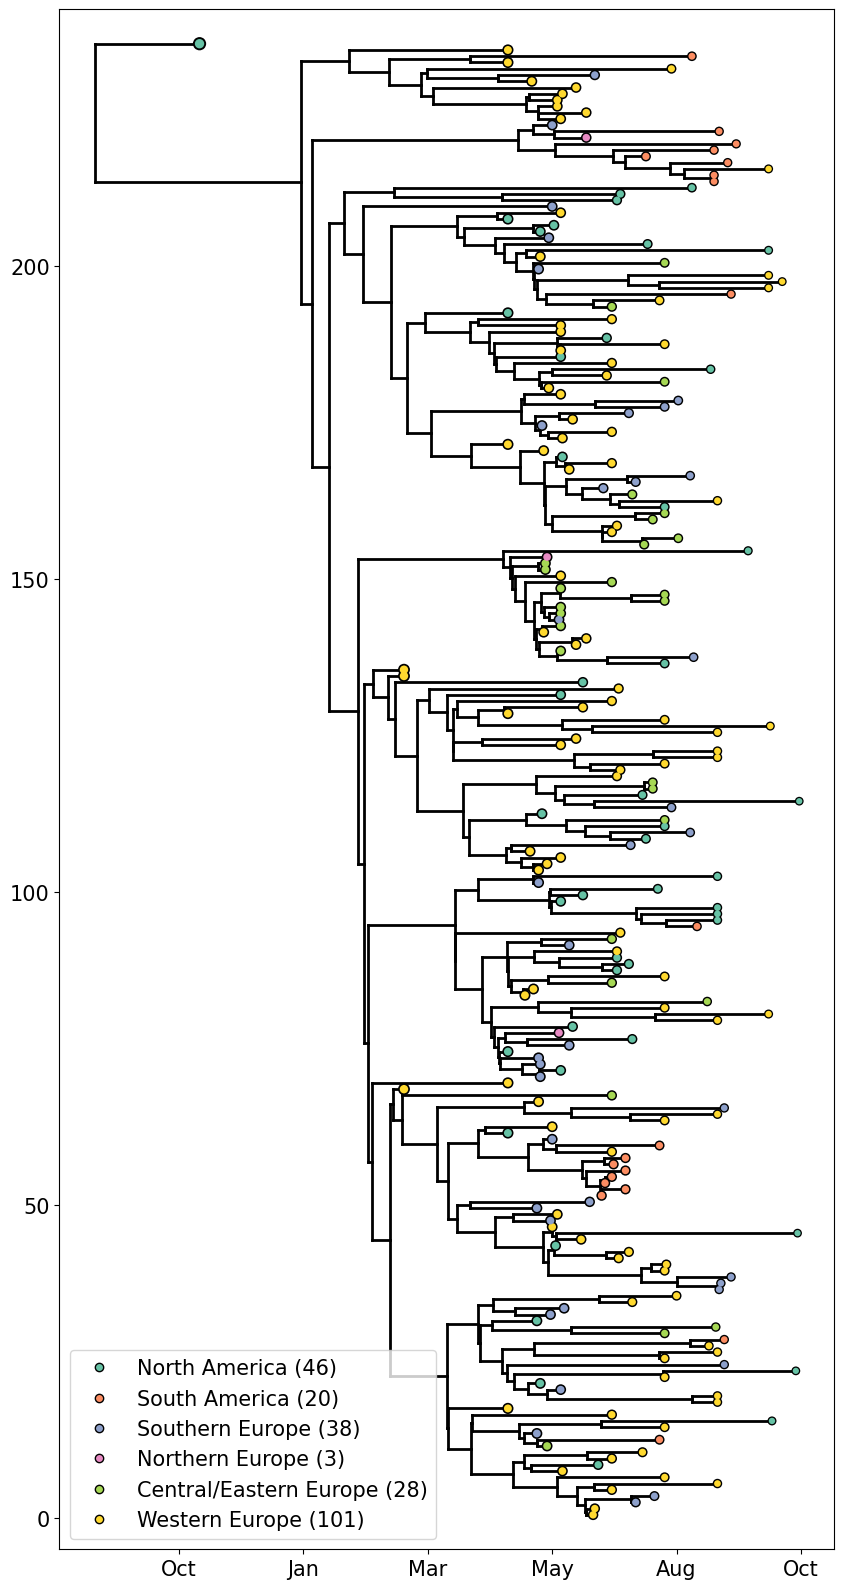

In [27]:
fig,ax = plt.subplots(figsize=(10,20),facecolor='w')

x_attr=lambda k: k.absoluteTime ## x coordinate of branches will be absoluteTime attribute
c_func=lambda k: color_code[k.traits['region']] if k.branchType=='leaf' else 'black'
s_func=lambda k: 50-30*k.height/t.treeHeight ## size of tips

t.plotTree(ax,x_attr=x_attr) ## plot branches
t.plotPoints(ax,x_attr=x_attr,size=s_func,colour=c_func,zorder=100) ## plot circles at tips

ax.set_ylim(-5,t.ySpan+5)
ax.ticklabel_format(useOffset=False)
ax.tick_params(labelsize=15)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(str_date))

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o',  markeredgecolor = 'black', linestyle='') for color in color_code.values()]
plt.legend(markers, color_code_n.keys(), numpoints=1, fontsize=15)

#plt.savefig('tree.png')
plt.show()

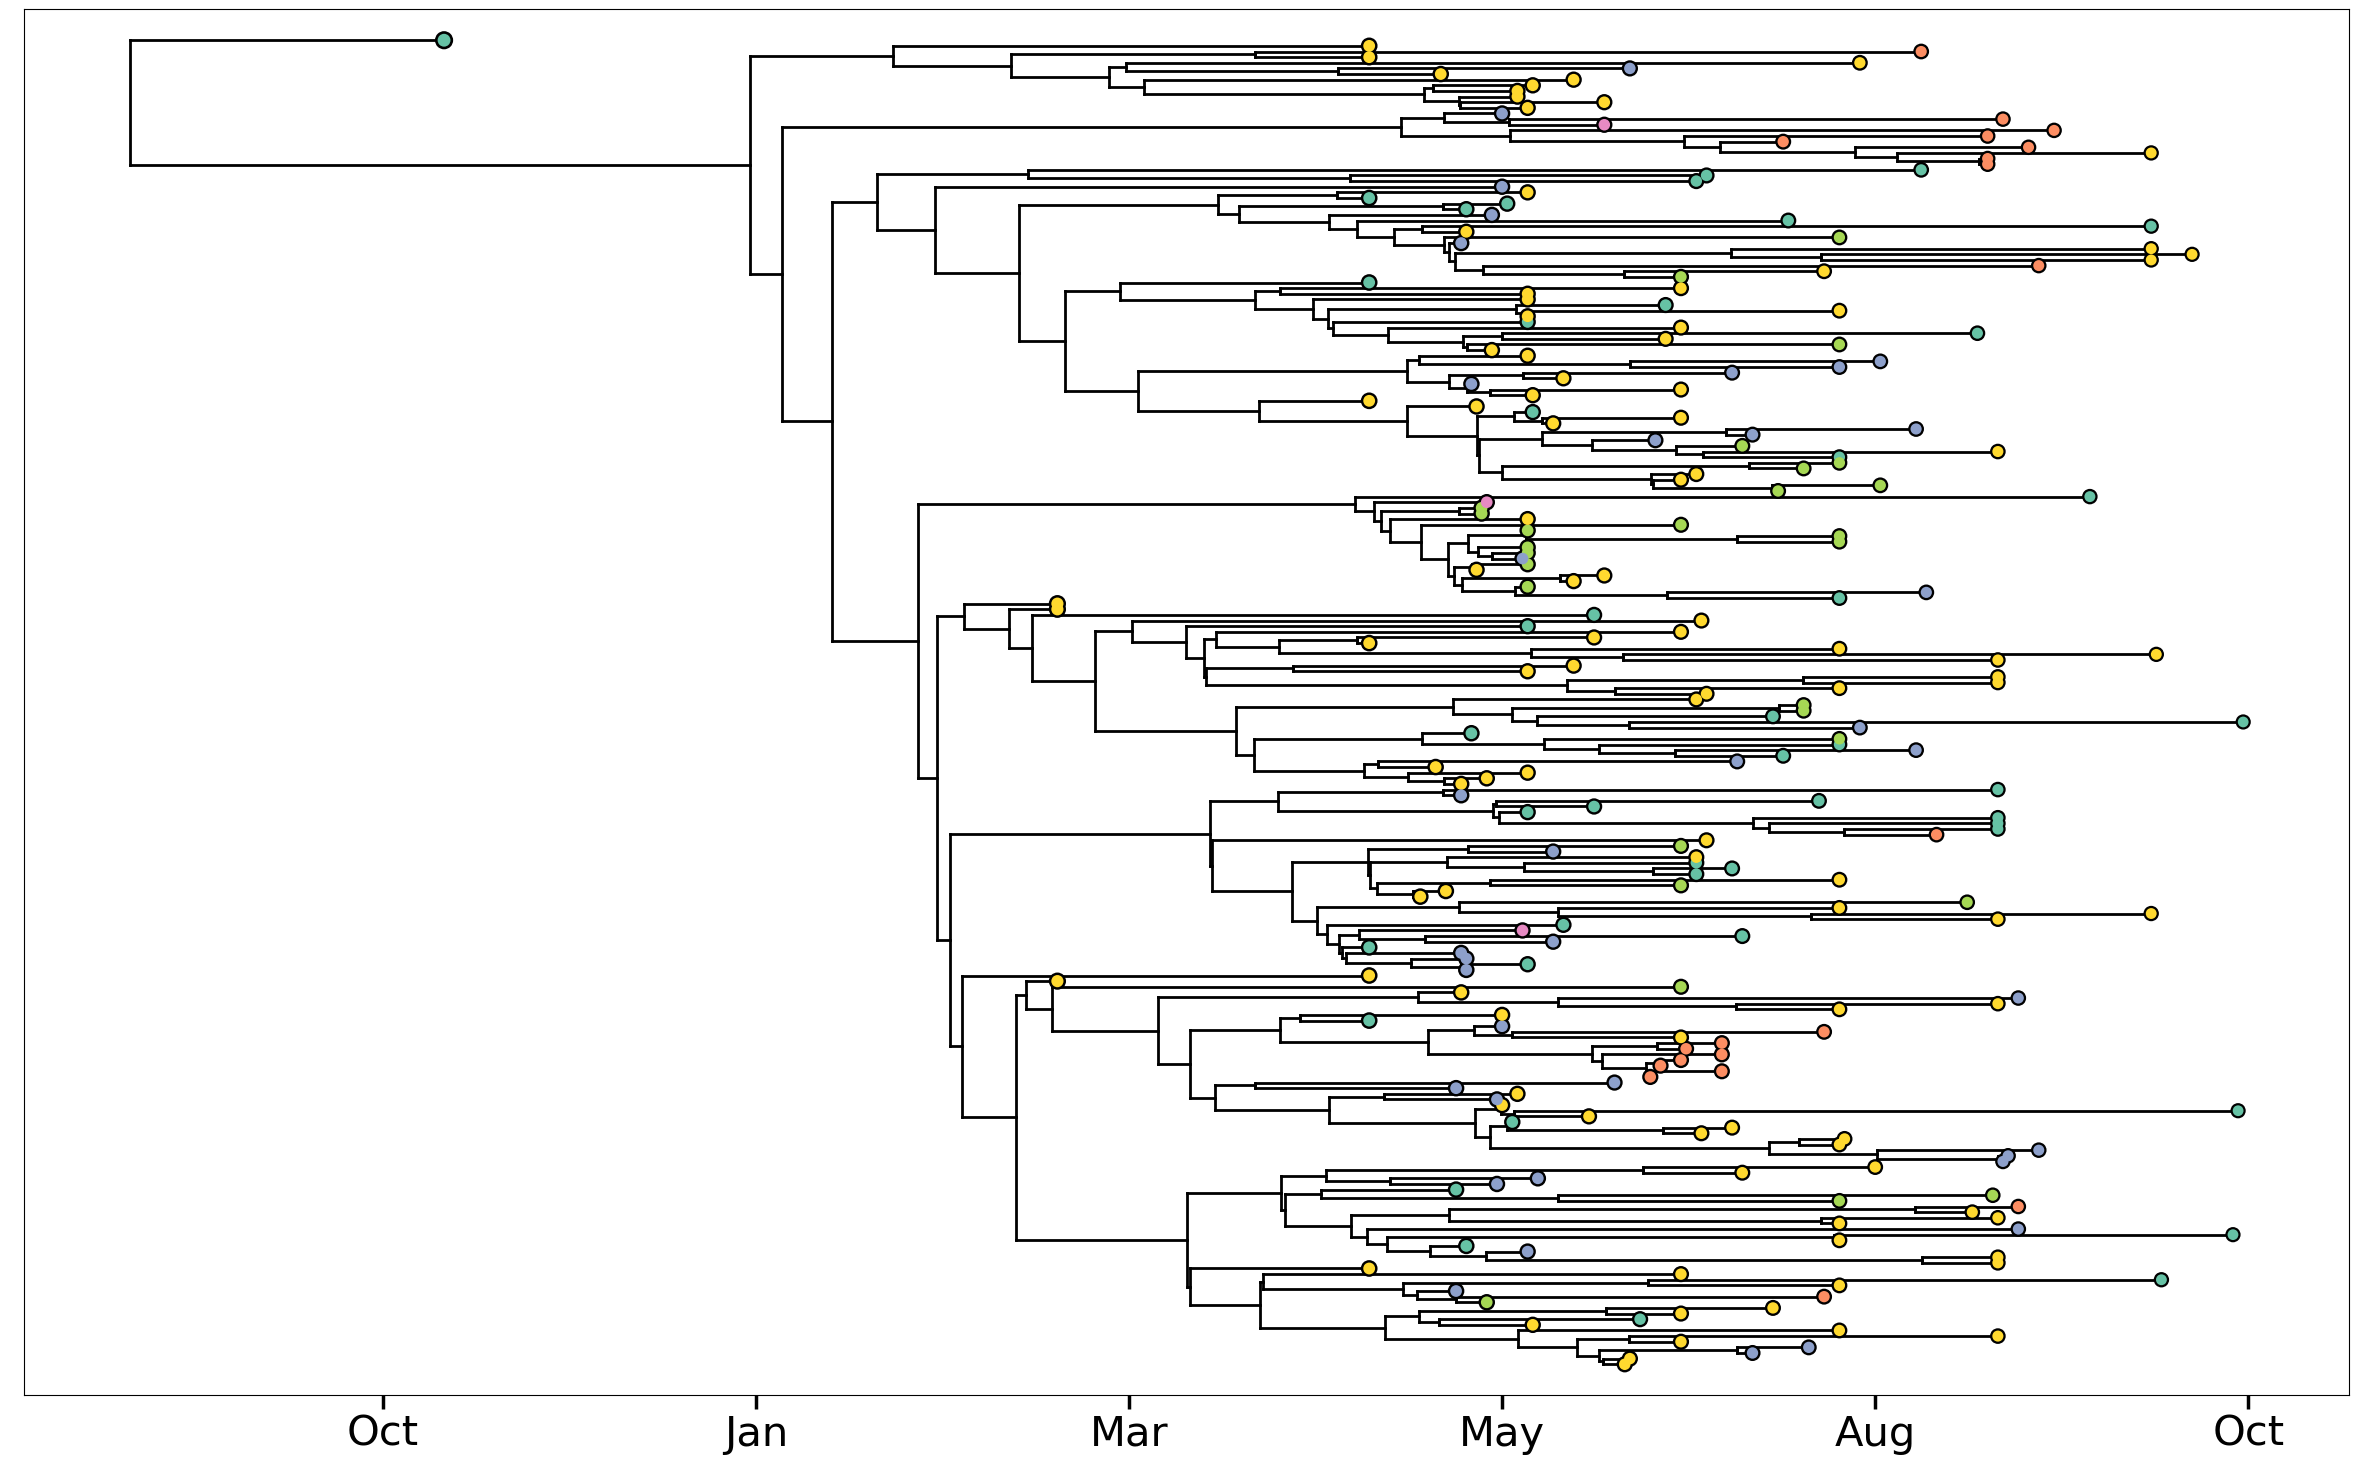

In [28]:
fig,ax = plt.subplots(figsize=(30,18),facecolor='w')

x_attr=lambda k: k.absoluteTime ## x coordinate of branches will be absoluteTime attribute
c_func=lambda k: color_code[k.traits['region']] if k.branchType=='leaf' else 'black'
s_func=lambda k: 90-30*k.height/t.treeHeight ## size of tips

t.plotTree(ax,x_attr=x_attr) ## plot branches
t.plotPoints(ax,x_attr=x_attr,size=s_func,colour=c_func,zorder=100) ## plot circles at tips

ax.set_ylim(-5,t.ySpan+5)
ax.ticklabel_format(useOffset=False)
ax.tick_params(labelsize=30, width=2.5, length=10)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(str_date))
ax.get_yaxis().set_visible(False)

#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o',  markeredgecolor = 'black', linestyle='', markersize=20) for color in color_code.values()]
#plt.legend(markers, color_code_n.keys(), numpoints=1, fontsize=20)

#plt.savefig('tree.png')
plt.show()

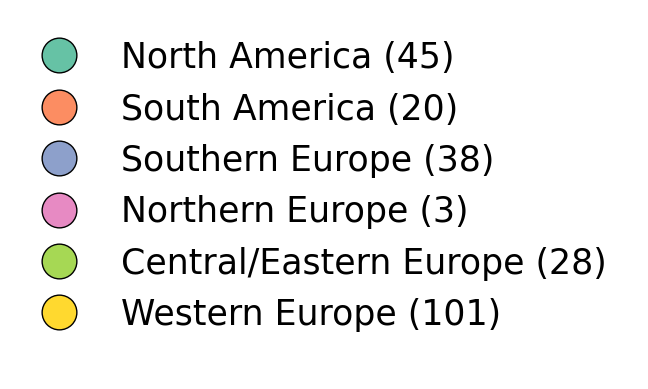

In [16]:
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o',  markeredgecolor = 'black', linestyle='', markersize=25) for color in color_code.values()]
plt.legend(markers, color_code_n.keys(), numpoints=1, fontsize=25, frameon=False)
plt.axis('off')
#plt.savefig('legend.png')
plt.show()


### assign color labels to countries

In [246]:
country_code = {} 

for country in country_counts: 
    for k, v in region.items():
        if country in k:
            country_code[country] = color_code[v]

country_code['United Kingdom'] = country_code.pop('UnitedKingdom')
country_code['United States of America'] = country_code.pop('USA')   

### draw map 
(if all else fails, https://www.mapchart.net/world.html ... ) 

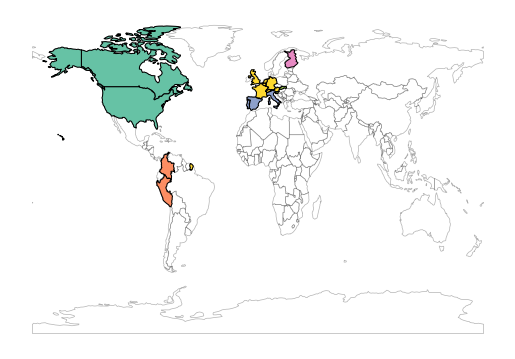

In [293]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(alpha=0.3, color="white", edgecolor="black", linewidth=0.5)

for country in country_code: 
    world[world.name == country].plot(color=country_code[country],
                                      ax=ax, edgecolor="black",
                                      linewidth=0.75)
ax.set_axis_off()
#plt.savefig('map.png')
plt.show()

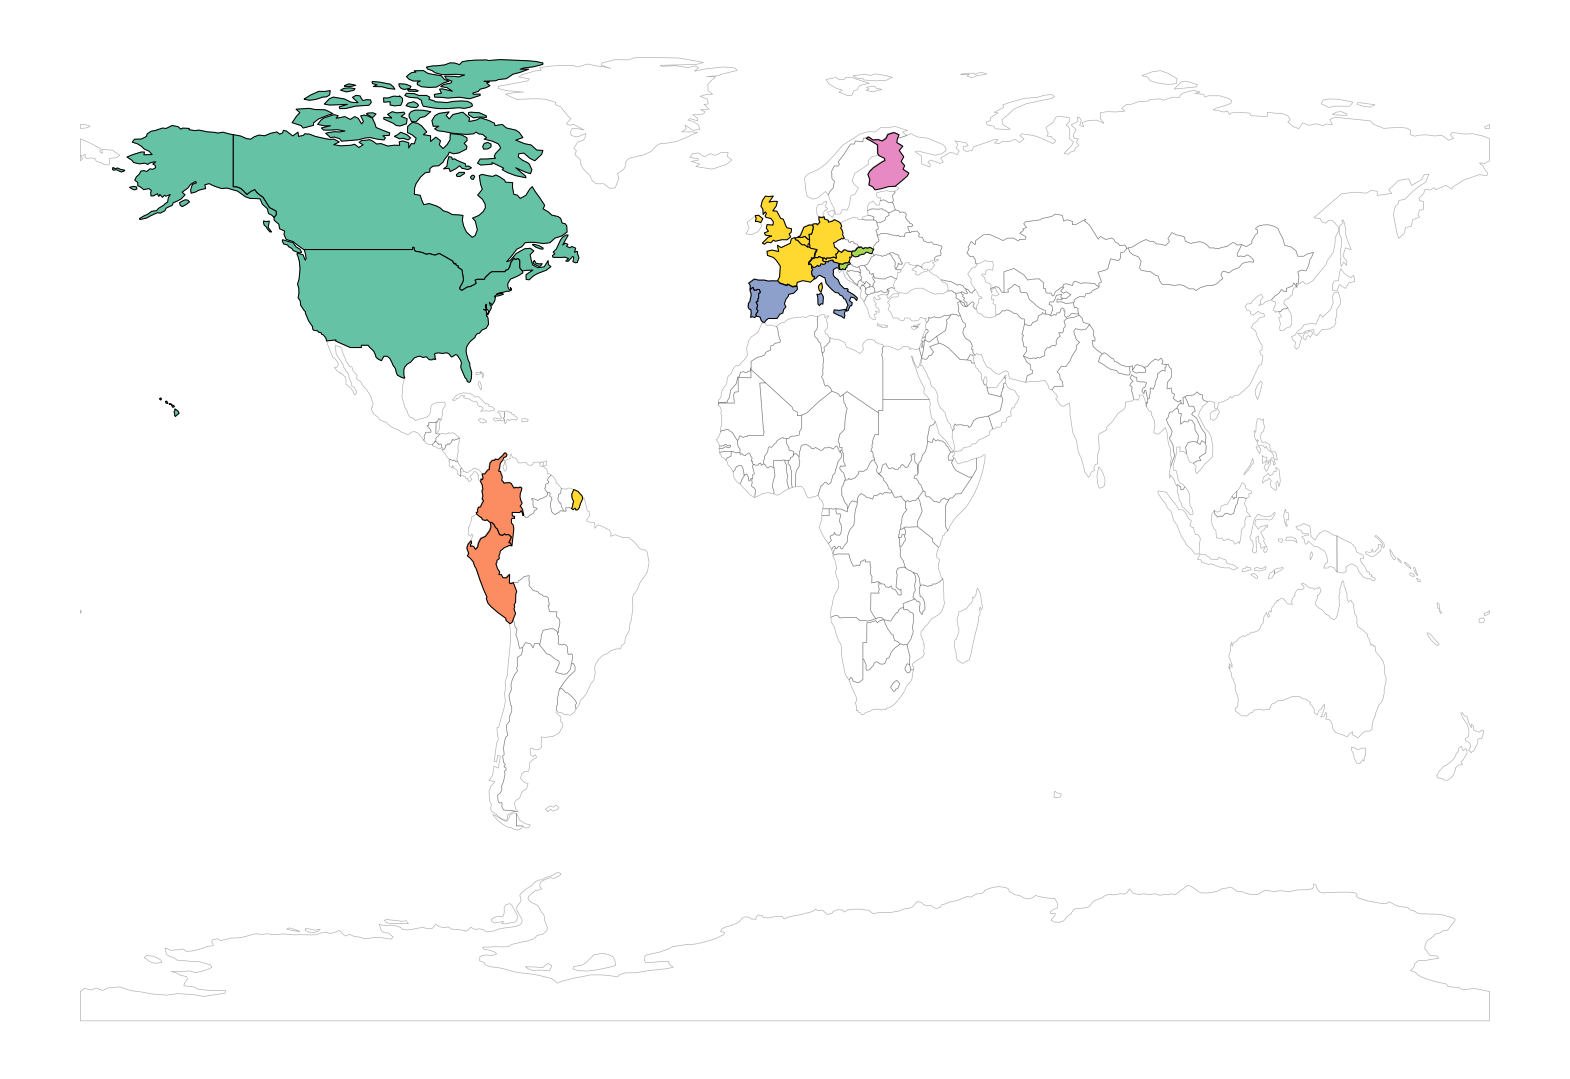

In [357]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(alpha=0.3, color="white", edgecolor="black", linewidth=0.5, figsize=(20,18))

for country in country_code: 
    world[world.name == country].plot(color=country_code[country],
                                      ax=ax, edgecolor="black",
                                      linewidth=0.75)
ax.set_axis_off()
plt.savefig('map_wide.png')
plt.show() 

### alpha according to counts from each country

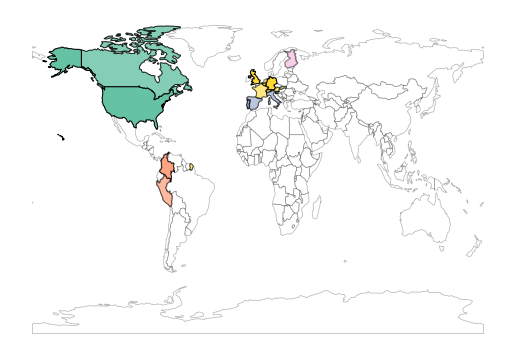

In [294]:
def alpha_world(country): 
    if country_counts[country] <=5: 
        a = 0.4
    if country_counts[country] <= 10 and country_counts[country] > 5:
        a = 0.6
    if country_counts[country] <= 25 and country_counts[country] > 10: 
        a = 0.8
    if country_counts[country] > 25: 
        a = 1
    return a

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(alpha=0.3, color="white", edgecolor="black", linewidth=0.5)

for country in country_code: 
    world[world.name == country].plot(color=country_code[country],
                                      ax=ax, edgecolor="black",
                                      linewidth=0.75,
                                      alpha=alpha_world(country))
ax.set_axis_off()

#plt.savefig('map_no_alpha.png')
plt.show()

### Notes
hide parts of map? https://geopandas.org/en/stable/docs/user_guide/indexing.html 
legend for country counts